In [294]:
import random
import numpy as np
from collections import defaultdict
import copy
import math

In [295]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [439]:
class Point:
    def __init__(self, x=0, y=0, cluster_id=None):
        self.x = x
        self.y = y
        self.cluster_id = cluster_id

    def euclidean_distance_to(self, other):
        return (self.x - other.x) ** 2 + (self.y - other.y) ** 2

    def __str__(self):
        return f"Point({self.x}, {self.y})"
    def __repr__(self):
        return f"Point(x={self.x}, y={self.y}, cluster_id={self.cluster_id})"
    def __eq__(self, other):
        if not isinstance(other, Point):
            return NotImplemented
        if self.cluster_id is not None and other.cluster_id is not None:
            return self.cluster_id == other.cluster_id
        return self.x == other.x and self.y == other.y and self.cluster_id == other.cluster_id
    def __hash__(self):
        if self.cluster_id is None:
            return hash((self.x, self.y, self.cluster_id))
        return hash(self.cluster_id)

In [297]:
def read_points_from_file(file_path: str) -> list[Point]:
    arr_points = np.loadtxt(file_path)          
    return [Point(float(x), float(y)) for x, y in arr_points]

In [298]:
def assign_centroids_on_random(points_list, k):
    centroids_list = []
    sampled_points = random.sample(points_list, k)
    for idx, point in enumerate(sampled_points):
        centroid = Point(point.x, point.y, cluster_id=idx)
        centroids_list.append(centroid)
    return centroids_list      

In [299]:
def assign_points_to_centroids(centroids_list, k, points_list):
    # loops over all points, calculates their distance to each centroid and assigns the point to the closest one; adds it to the dict
    dict_clusters = defaultdict(list)
    for point in points_list:
        min_dist_to_centroid = np.inf
        point_centroid = centroids_list[0]

        for centroid in centroids_list:
            current_dist = point.euclidean_distance_to(centroid)
            if current_dist < min_dist_to_centroid:
                min_dist_to_centroid = current_dist
                point_centroid = centroid

        point.cluster_id = point_centroid.cluster_id
        dict_clusters[point_centroid.cluster_id].append(point)

    return dict_clusters

In [300]:
def update_centroid(assigned_points, centroid, points_list):
    if assigned_points is None:
        return centroid
    points_count = len(assigned_points)
    if points_count == 0:
        random_point = random.choice(points_list)
        return Point(random_point.x, random_point.y, cluster_id=centroid.cluster_id)      

    sum_x = 0.0
    sum_y = 0.0
    for p in assigned_points:
        sum_x += p.x
        sum_y += p.y
    return Point(sum_x / points_count, sum_y / points_count, cluster_id=centroid.cluster_id)

In [440]:
def update_centroids(centroids_list, dict_clusters, points_list):
    new_centroids_list = []
    for centroid in centroids_list:
        assigned_points = dict_clusters.get(centroid.cluster_id, [])
        new_centroid = update_centroid(assigned_points, centroid, points_list)
        if new_centroid is None:
            new_centroid = centroid  
        new_centroids_list.append(new_centroid)
    return new_centroids_list

In [302]:
def wcss_eval(centroids_list, dict_clusters):   # later I will call it multiple times in kMeans, save the corresponding dict_clusters each time and return the one with lowest wcss
    wcss_result = 0.0
    for centroid in centroids_list:
        current_wcss = 0.0
        assigned_points = dict_clusters.get(centroid.cluster_id, [])
        for point in assigned_points:
            current_wcss += point.euclidean_distance_to(centroid)
        wcss_result += current_wcss
    return wcss_result

In [389]:
def get_closest_cluster(centroid, centroids_list):
    min_distance = np.inf
    closest_centroid = centroid
    for current_centroid in centroids_list:
        if current_centroid == centroid:
            continue
        current_dist = math.sqrt(centroid.euclidean_distance_to(current_centroid))
        if current_dist < min_distance:
            min_distance = current_dist
            closest_centroid = current_centroid
    return closest_centroid           

In [390]:
def silhouette_score(centroids_list, dict_clusters):   # again I will keep the different scores and their corresponding dict_clusters dicts and return the one with HIGHEST score (at least > 0.5, ideally > 0.7)
    total_silhouette_score = 0.0
    total_points = 0

    for centroid in centroids_list:
        assigned_points = dict_clusters.get(centroid.cluster_id, [])
        if len(assigned_points) <= 1:
            continue

        closest_centroid = get_closest_cluster(centroid, centroids_list)
        assigned_points_closest = dict_clusters.get(closest_centroid.cluster_id, [])
        if len(assigned_points_closest) == 0:
            continue

        for point in assigned_points:
            a_i = 0.0
            b_i = 0.0

            for other_point in assigned_points:
                if other_point != point:
                    a_i += math.sqrt(point.euclidean_distance_to(other_point))
            a_i /= (len(assigned_points) - 1)

            for other_point in assigned_points_closest:
                b_i += math.sqrt(point.euclidean_distance_to(other_point))
            b_i /= len(assigned_points_closest)

            s_i = (b_i - a_i) / max(a_i, b_i)
            total_silhouette_score += s_i
            total_points += 1

    return total_silhouette_score / total_points if total_points > 0 else 0.0

In [391]:
def termination_condition(old_centroids, new_centroids, threshold=1e-4):  #kMeans terminates when clusters stop changing their centroids
    total_movement = 0.0
    for old_centroid, new_centroid in zip(old_centroids, new_centroids):
        total_movement += old_centroid.euclidean_distance_to(new_centroid)
    return total_movement < threshold

In [427]:
def k_means(evaluation_metrics, k, points_list, centroids_list): 
    best_dict_clusters = None
    old_centroids_list = None
    isFirstIteration = True
    best_eval = np.inf if evaluation_metrics == 1 else -np.inf
    iteration = 0
    
    while isFirstIteration or not termination_condition(old_centroids_list, centroids_list):
        isFirstIteration = False        

        dict_clusters = assign_points_to_centroids(centroids_list, k, points_list)
        old_centroids_list = copy.deepcopy(centroids_list)
        centroids_list = update_centroids(centroids_list, dict_clusters, points_list)    
            
    dict_clusters = assign_points_to_centroids(centroids_list, k, points_list)
    if evaluation_metrics == 1:            
        best_eval = wcss_eval(centroids_list, dict_clusters)
        
    elif evaluation_metrics == 2:            
        best_eval = silhouette_score(centroids_list, dict_clusters)
    
    best_dict_clusters = copy.deepcopy(dict_clusters)
    return best_eval, best_dict_clusters

In [426]:
def compare_results(old_score, old_dict_clusters, current_score, current_dict_clusters, evaluation_metrics):
    if evaluation_metrics == 1:   #wcss score
        if current_score < old_score:
            return current_score, current_dict_clusters
        else:
            return old_score, old_dict_clusters
    elif evaluation_metrics == 2:   #silhouette score
        if current_score > old_score:
            return current_score, current_dict_clusters
        else:
            return old_score, old_dict_clusters       

In [428]:
def run_k_means_with_random_restart(file_name, evaluation_metrics, k, runs_count):
    best_score = np.inf if evaluation_metrics == 1 else -np.inf
    best_dict_clusters = None
    number_of_iterations = 0
    points_list = read_points_from_file(file_name)
    while number_of_iterations <= runs_count:
        centroids_list = assign_centroids_on_random(points_list, k)
        current_eval, current_dict_clusters = k_means(evaluation_metrics, k, points_list, centroids_list)
        best_score, best_dict_clusters = copy.deepcopy(compare_results(best_score, best_dict_clusters, current_eval, current_dict_clusters, evaluation_metrics))
        number_of_iterations += 1
    return  best_dict_clusters

In [429]:
def assign_centroids_kmeans_plus_plus(points_list, k):
    first = random.choice(points_list)
    centroids = [Point(first.x, first.y, cluster_id=0)]

    while len(centroids) < k:
        d = []
        for p in points_list:
            di = min(p.euclidean_distance_to(c) for c in centroids)
            d.append(di)

        total = sum(d)
        if total == 0:
            p = random.choice(points_list)
        else:
            r = random.random() * total
            s = 0.0
            p = points_list[-1]
            for pi, di in zip(points_list, d):
                s += di
                if s >= r:
                    p = pi
                    break

        centroids.append(Point(p.x, p.y, cluster_id=len(centroids)))

    return centroids

In [430]:
def run_k_means_plus_plus(file_name, evaluation_metrics, k):
    best_score = np.inf if evaluation_metrics == 1 else -np.inf
    best_dict_clusters = None
   
    points_list = read_points_from_file(file_name)
   
    centroids_list = assign_centroids_kmeans_plus_plus(points_list, k)
    current_eval, current_dict_clusters = k_means(evaluation_metrics, k, points_list, centroids_list)
    best_score, best_dict_clusters = copy.deepcopy(compare_results(best_score, best_dict_clusters, current_eval, current_dict_clusters, evaluation_metrics))
       
    return  best_dict_clusters

In [431]:
def save_coordinates_to_files(dict_centroid_points, data_path, centroids_path, labels_path):
    cluster_ids = sorted(dict_centroid_points.keys())

    # write centroids in the same order as cluster_ids
    with open(centroids_path, "w", encoding="utf-8") as f_centroids:
        for cid in cluster_ids:
            pts = dict_centroid_points.get(cid, [])
            if len(pts) == 0:
                f_centroids.write("0 0\n")
                continue

            sum_x = 0.0
            sum_y = 0.0
            for p in pts:
                sum_x += p.x
                sum_y += p.y
            f_centroids.write(f"{sum_x / len(pts)} {sum_y / len(pts)}\n")

    # write all points + labels aligned with the above centroid order
    with open(data_path, "w", encoding="utf-8") as f_data, \
         open(labels_path, "w", encoding="utf-8") as f_labels:
        for idx, cid in enumerate(cluster_ids):
            for p in dict_centroid_points.get(cid, []):
                f_data.write(f"{p.x} {p.y}\n")
                f_labels.write(f"{idx}\n")

In [432]:
def plot_data_and_centroids(data_file, centroids_file, labels_file):
    X = np.loadtxt(data_file)
    centroids = np.loadtxt(centroids_file)
    labels = np.loadtxt(labels_file, dtype=int)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='Set1', s=100, legend='full')

    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=300, marker='X', label='Centroids')
    
    plt.title('Data and Centroids Visualization')
    plt.legend()
    plt.show()

if __name__ == "__main__":
    if len(sys.argv) != 4:
        print("Usage: python plot_clusters.py <data_file> <centroids_file> <labels_file>")
        sys.exit(1)

    data_file = sys.argv[1]
    centroids_file = sys.argv[2]
    labels_file = sys.argv[3]
    plot_data_and_centroids(data_file, centroids_file, labels_file)

Usage: python plot_clusters.py <data_file> <centroids_file> <labels_file>


SystemExit: 1

c:\Users\Hristina.Frangova\FMI\PracticalPythonCourse\HW1\mypythonenv\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


I. Testing kMeans algorithm with WCSS and silhouette score and different number of iterations.

1. Test on the unbalanced set.

    A) With the WCSS score

In [317]:
dict_clusters = run_k_means_with_random_restart("unbalance.txt", 1, 8, 70)
save_coordinates_to_files(dict_clusters,
                 "data_out.txt", "centroids_out.txt", "labels_out.txt")

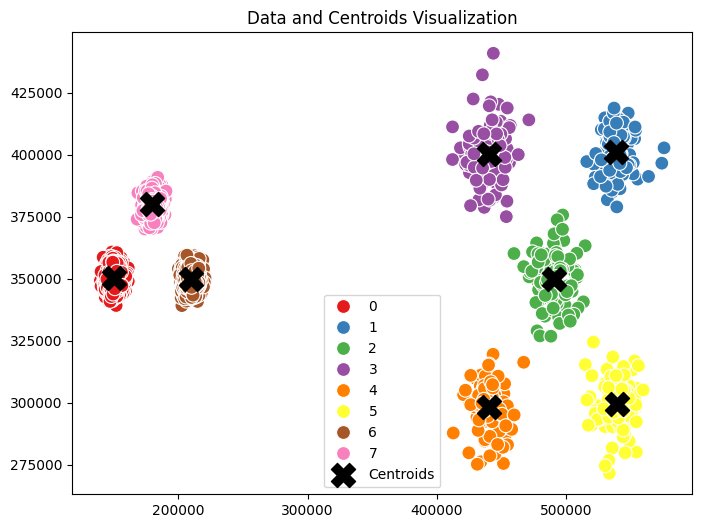

In [318]:
plot_data_and_centroids("data_out.txt", "centroids_out.txt", "labels_out.txt")

Some observations:

The number of iterations for my tests above (using kMeans with wcss score and 8 clusters on unbalanced data) turned out to be critical. Only with around 70 iterations did I get satisfactory results. With less repeats the kMeans algorithm managed to outline clearly only 5 clusters (at most). On the opposite - with more than 70 runs (i.e. with 100 iteraions), output suddenly worsens - it was better than the one with 8 iterations (3-5 clusters discovered only) and yet it found again at most 5 clusters. This may be because of overcalculations that may blur clusters. Or my result above may be the outcome of a lucky initial random distribution of centroids, which just was not repeated later.

The old results are below:

In [413]:
dict_clusters = run_k_means_with_random_restart("unbalance.txt", 1, 8, 20)
save_coordinates_to_files(dict_clusters,
                 "old_data_out.txt", "old_centroids_out.txt", "old_labels_out.txt")

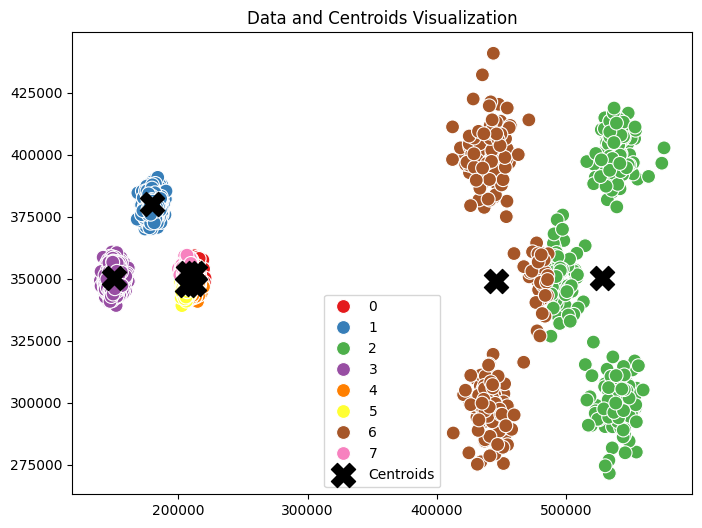

In [414]:
plot_data_and_centroids("old_data_out.txt", "old_centroids_out.txt", "old_labels_out.txt")

B) With the silhouette score

In [415]:
dict_clusters = run_k_means_with_random_restart("unbalance.txt", 2, 8, 20)
save_coordinates_to_files(dict_clusters,
                 "sil_data_out.txt", "sil_centroids_out.txt", "sil_labels_out.txt")

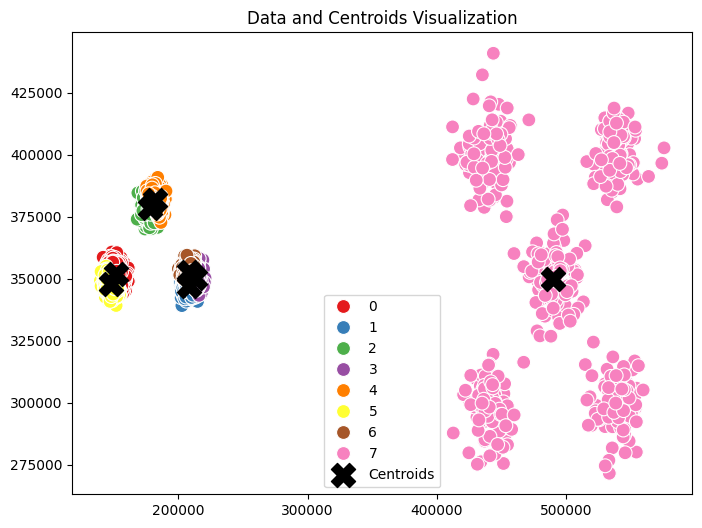

In [416]:
plot_data_and_centroids("sil_data_out.txt", "sil_centroids_out.txt", "sil_labels_out.txt")

Still poor results using silhouette score on unbalanced data, although I tried it with different number of iterations. It performs quite slowly as well because of the numerous inter- and intra-cluster calculations that have to be made. No matter that silhouette analysis is theoretically more precise than WCSS (since it considers distance between points of different clusters as well), it still performs worse than kMeans using the WCSS score. This is mainly because the data set is unbalanced which results in the values of ai and bi in the silhouette's analysis formula, misleading the algorithm.

2. Test on the set of normally-distributed data points.

    A) with WCSS evaluation score

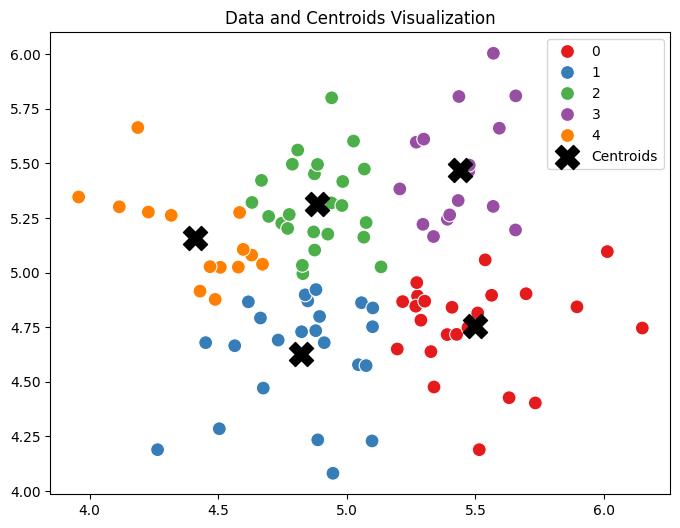

In [400]:
dict_clusters = run_k_means_with_random_restart("normal.txt", 1, 5, 8)
save_coordinates_to_files(dict_clusters,
                 "normal_data_out.txt", "normal_centroids_out.txt", "normal_labels_out.txt")

plot_data_and_centroids("normal_data_out.txt", "normal_centroids_out.txt", "normal_labels_out.txt")

    B) With the silhouette score

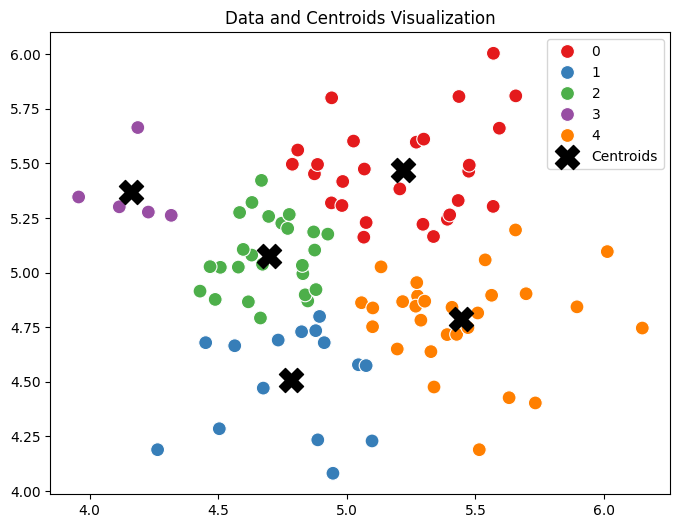

In [401]:
dict_clusters = run_k_means_with_random_restart("normal.txt", 2, 5, 8)
save_coordinates_to_files(dict_clusters,
                 "sil_normal_data_out.txt", "sil_normal_centroids_out.txt", "sil_normal_labels_out.txt")

plot_data_and_centroids("sil_normal_data_out.txt", "sil_normal_centroids_out.txt", "sil_normal_labels_out.txt")

II. Testing kMeans++ algorithm with WCSS and silhouette score.
1. On unbalanced data.

    A) With WCSS score

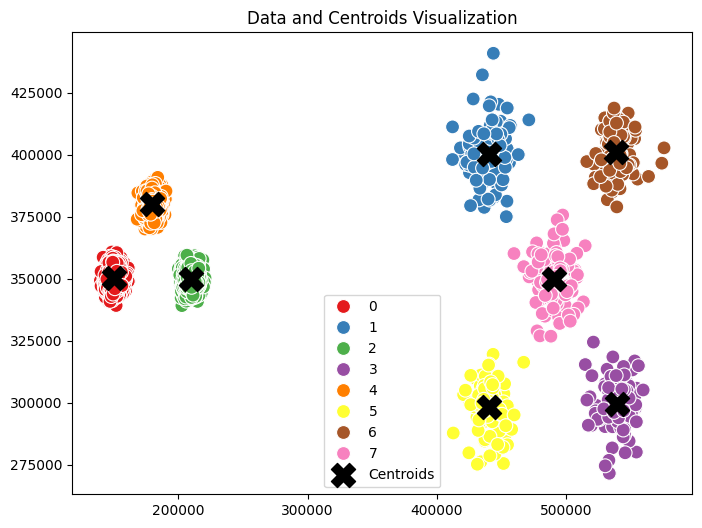

In [433]:
dict_clusters = run_k_means_plus_plus("unbalance.txt", 1, 8)
save_coordinates_to_files(dict_clusters,
                 "kmeans++_data_out.txt", "kmeans++_centroids_out.txt", "kmeans++_labels_out.txt")
plot_data_and_centroids("kmeans++_data_out.txt", "kmeans++_centroids_out.txt", "kmeans++_labels_out.txt")

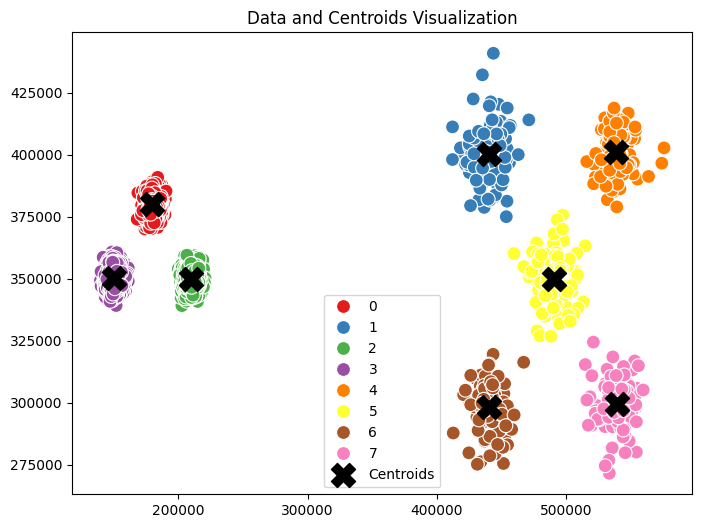

In [436]:
dict_clusters = run_k_means_plus_plus("unbalance.txt", 2, 8)
save_coordinates_to_files(dict_clusters,
                 "sil_kmeans++_data_out.txt", "sil_kmeans++_centroids_out.txt", "sil_kmeans++_labels_out.txt")
plot_data_and_centroids("sil_kmeans++_data_out.txt", "sil_kmeans++_centroids_out.txt", "sil_kmeans++_labels_out.txt")

As the results above show, kMeans++ performs much faster and with better results than its ancestor because of the smart initialization of centroids. Instead of calling the usual kMeans numerous times (around 70) and applying random restart for centroids' initialization, here we call the "plus plus"-version only once and let it run with several updates utill convergence. So the result is almost guaranteed within a SINGLE iteration of the algorithm.

Moreover, contrary to the kMeans algorithm, the evaluation metrics is not that much of an importance: with both WCSS and silhouette score we get the desired result.


2. On normally distributed data.

    A) With WCSS score

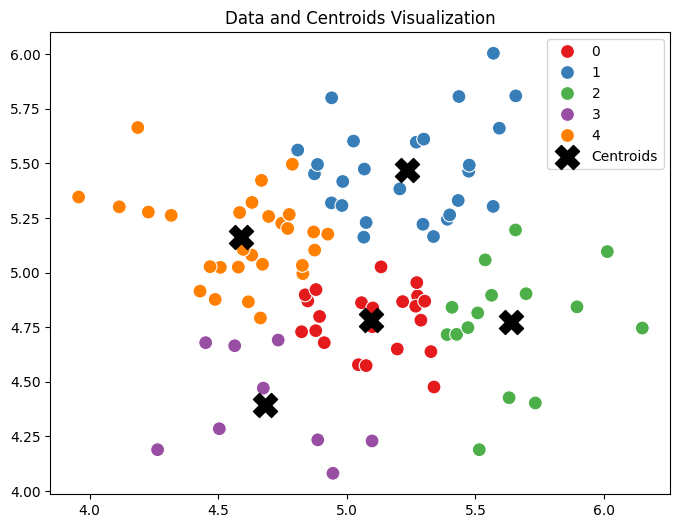

In [437]:
dict_clusters = run_k_means_plus_plus("normal.txt", 1, 5)
save_coordinates_to_files(dict_clusters,
                 "kmeans++_normal_data_out.txt", "kmeans++_normal_centroids_out.txt", "kmeans++_normal_labels_out.txt")
plot_data_and_centroids("kmeans++_normal_data_out.txt", "kmeans++_normal_centroids_out.txt", "kmeans++_normal_labels_out.txt")

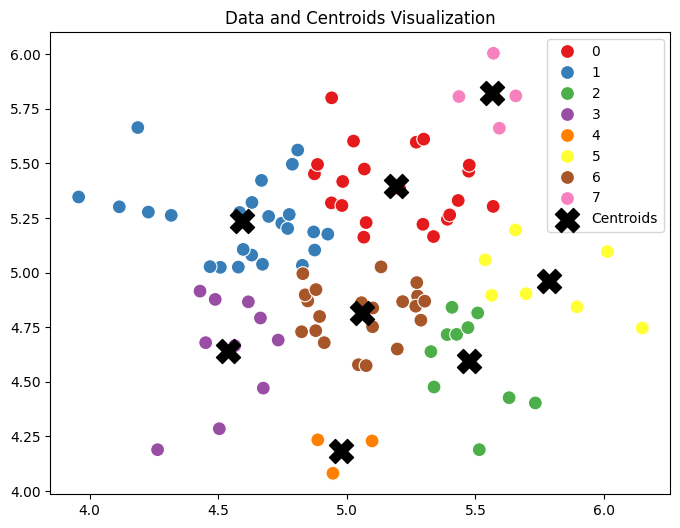

In [438]:
dict_clusters = run_k_means_plus_plus("normal.txt", 2, 8)
save_coordinates_to_files(dict_clusters,
                 "sil_normal_kmeans++_data_out.txt", "sil_normal_kmeans++_centroids_out.txt", "sil_normal_kmeans++_labels_out.txt")
plot_data_and_centroids("sil_normal_kmeans++_data_out.txt", "sil_normal_kmeans++_centroids_out.txt", "sil_normal_kmeans++_labels_out.txt")